# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import	accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score


**2. Data Loading and understanding**

In [2]:
df = pd.read_csv("/content/telco.csv")

In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
pd.set_option("display.max_columns",None)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# droping customerID column as this is not required for modelling
df = df.drop(columns = ["customerID"])

In [8]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
print(df["gender"].unique())

['Female' 'Male']


In [10]:
# print the unique values in all the columns
numerical_features_list = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in df.columns:
  if col not in numerical_features_list:
    print(col,df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

In [11]:
#df["TotalCharges"] = df["TotalCharges"].astype(float)

In [12]:
len(df[df["TotalCharges"]== " "])

11

In [13]:
df['TotalCharges'].replace({" " : "0.0"},inplace=True)

<ipython-input-13-a6fac4babd1c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].replace({" " : "0.0"},inplace=True)


In [14]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [15]:
# checking the distribution of target column
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**Insight:**
1. CustomerID removed as it not required for modelling
2. No missing value in the dataset
3. Missing values in the TotalCharges column were replace
4. Class imbalance identified in the target

# 3. Explotary Data Analysis(EDA)

In [16]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [17]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [18]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


**Numerical Features - Analysis**



*   Understand the distribution of the Numerical features



    

In [19]:
def plot_hist(df,columns_name):
  plt.figure(figsize=(10,6))
  sns.histplot(df[columns_name],kde=True)
  plt.title(f"Distribution of {columns_name}")
  #Calculate the mean and median values for the columns
  col_mean = df[columns_name].mean()
  col_median = df[columns_name].median()

  # add vertical line for mean and medain
  plt.axvline(col_mean,color="red",linestyle="dashed",linewidth=1,label = "Mean")
  plt.axvline(col_median,color="green",linestyle="dashed",linewidth=1,label = "Median")
  plt.legend()
  plt.show()

  plt.show()


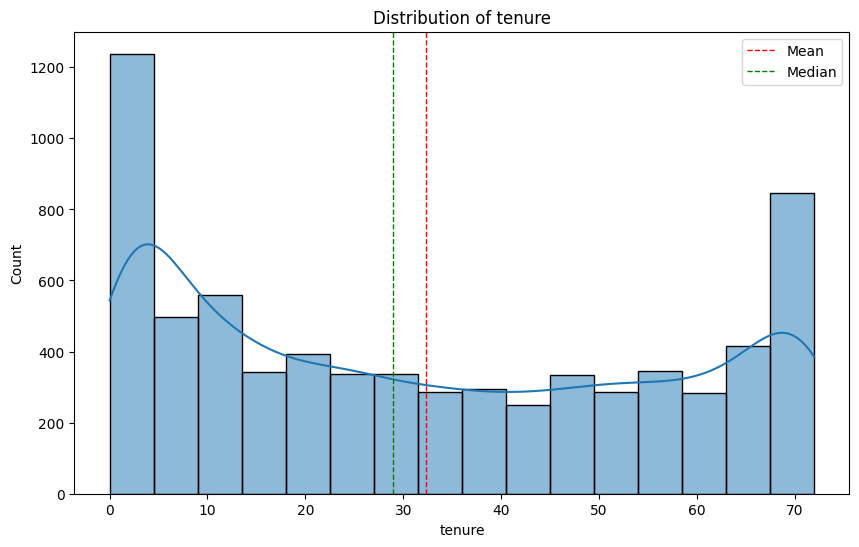

In [20]:
plot_hist(df,'tenure')

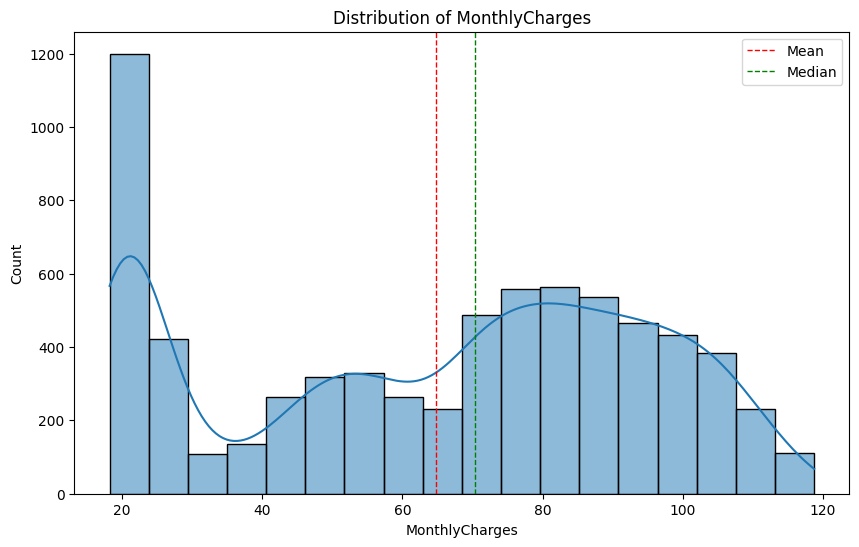

In [21]:
plot_hist(df,"MonthlyCharges")

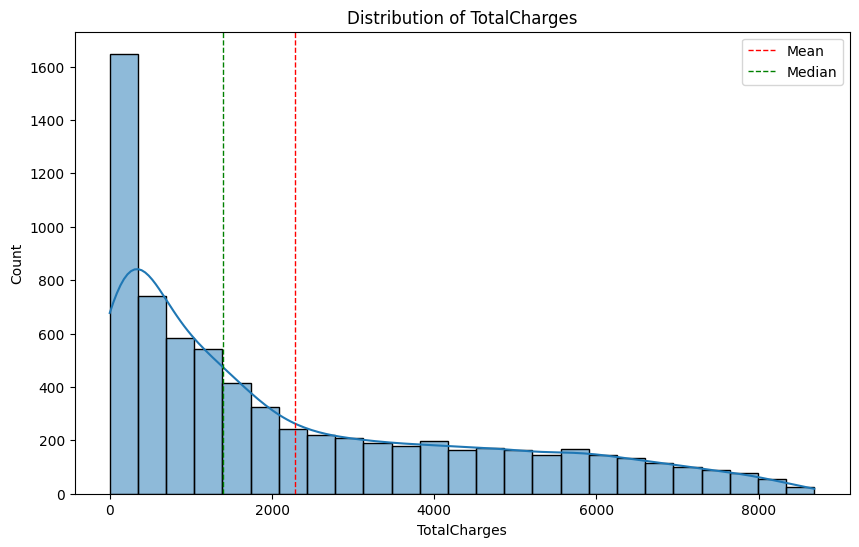

In [22]:
plot_hist(df,"TotalCharges")

Box plot for numerical features

In [23]:
def box_plot(df,columns_name):
  plt.figure(figsize=(5,3))
  sns.boxplot(y = df[columns_name])
  plt.title(f"Box Plot {columns_name}")
  plt.ylabel(columns_name)
  plt.show()

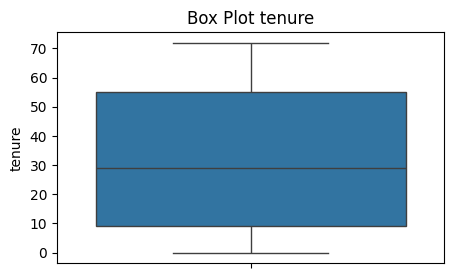

In [24]:
box_plot(df,"tenure")

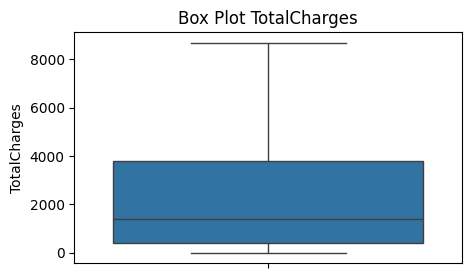

In [25]:
box_plot(df,"TotalCharges")

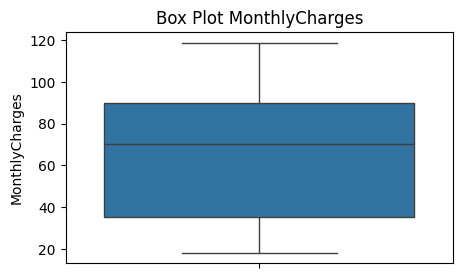

In [26]:
box_plot(df,"MonthlyCharges")

Corelation Heatmap for numerical columns


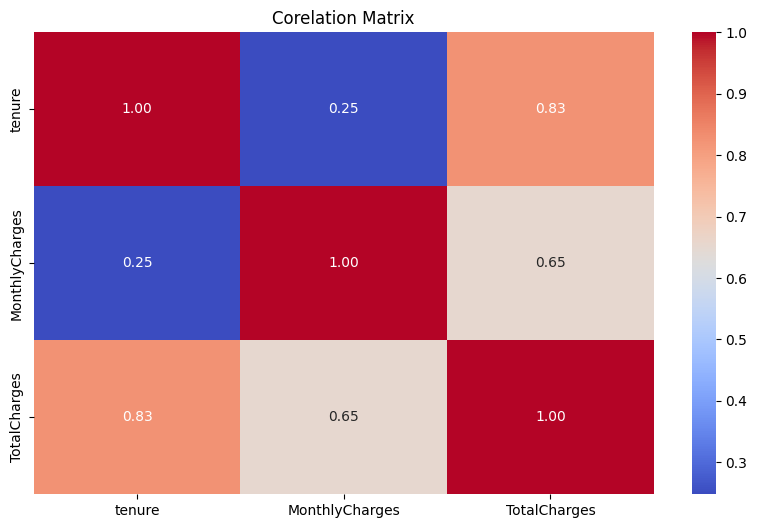

In [27]:
# corelation matrix - heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(),annot=True,cmap="coolwarm",fmt='.2f')
plt.title("Corelation Matrix")
plt.show()

Categorical Features - Analysis

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


countplot for categorical columns

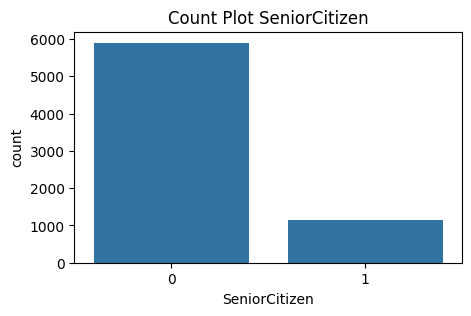

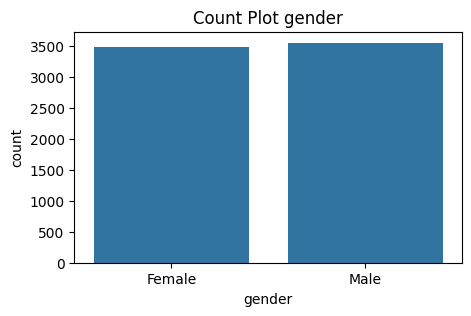

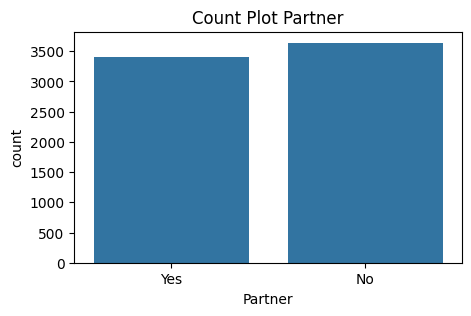

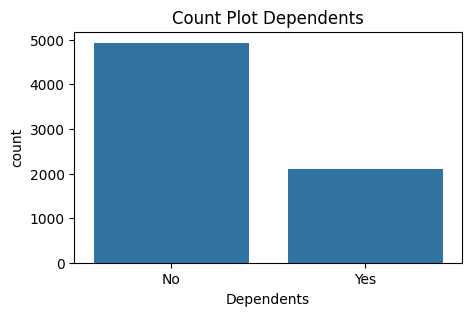

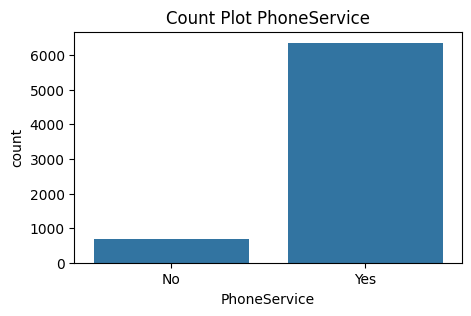

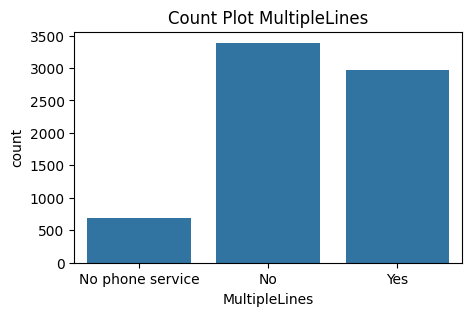

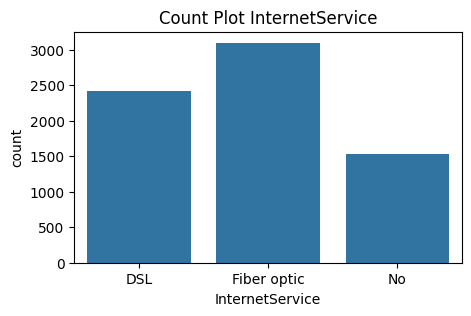

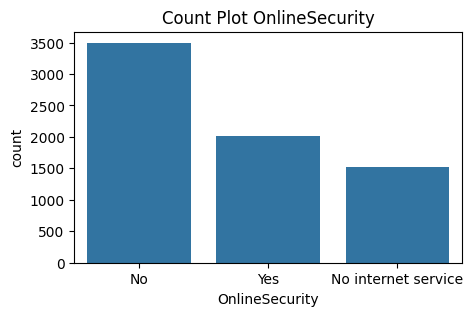

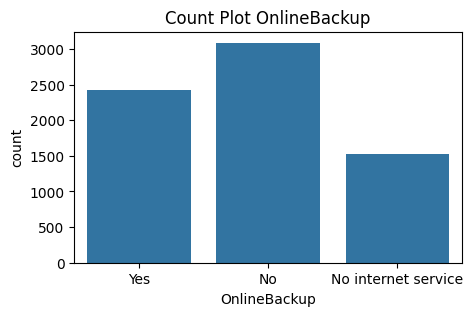

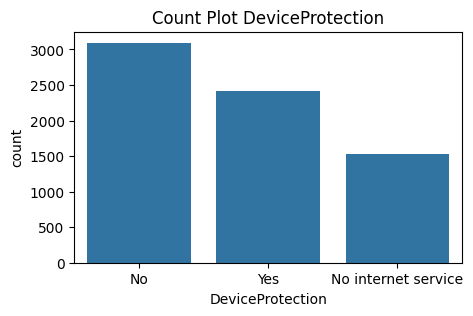

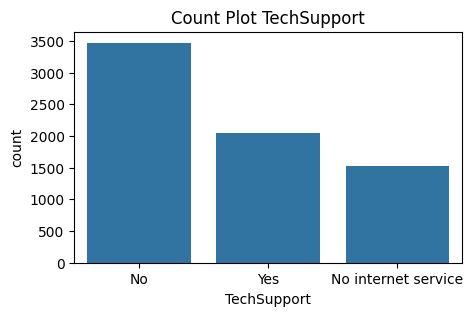

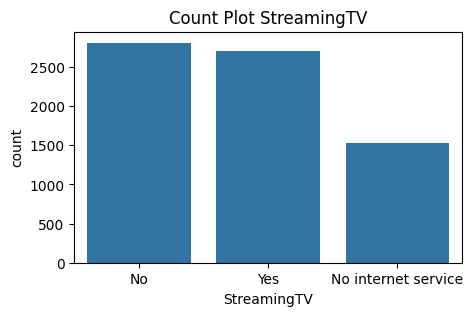

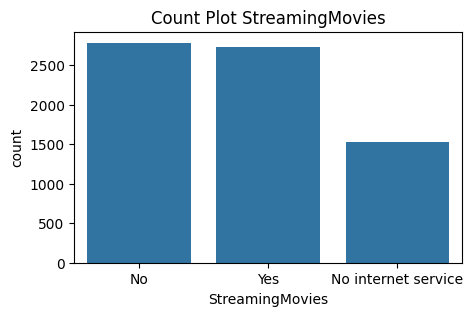

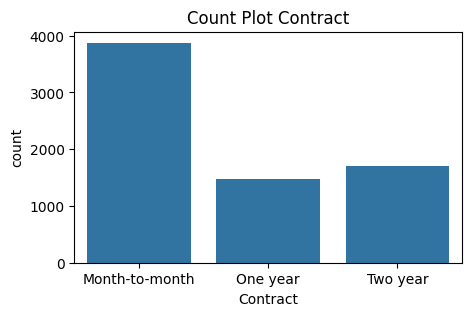

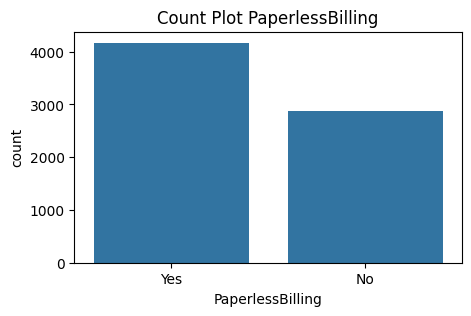

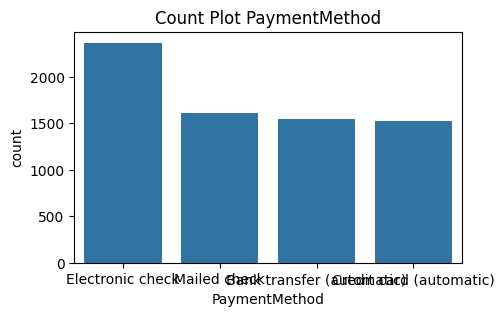

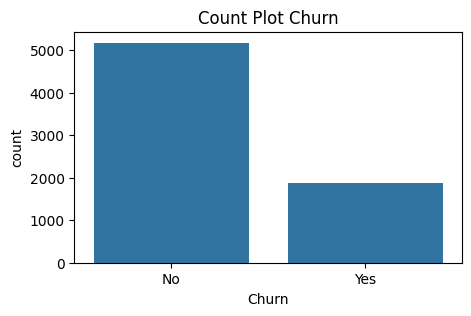

In [29]:
objects_column = df.select_dtypes(include="object").columns.to_list()
objects_column = ["SeniorCitizen"] + objects_column
for col in objects_column:
  plt.figure(figsize=(5,3))
  sns.countplot(x = df[col])
  plt.title(f"Count Plot {col}")
  plt.show()

**4. Data Preprocessing**

In [30]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Label encoder of target column

In [31]:
df['Churn'] = df['Churn'].replace({"Yes":1,"No":0})

<ipython-input-31-17c77b8740ed>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({"Yes":1,"No":0})


In [32]:
print(df['Churn'].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


Label encoding of categorical features

In [33]:
# identifying columns with objects data types
objects_column = df.select_dtypes(include="object").columns


In [34]:
print(objects_column)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [35]:
# initialize the dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for col in objects_column:
  label_encoder = LabelEncoder()
  df[col] = label_encoder.fit_transform(df[col])
  encoders[col] = label_encoder

# save the encoder to pickle file
with open("encoders.pkl","wb") as file:
  pickle.dump(encoders,file)

In [36]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1


Training and test data split

In [37]:
# spliting the features and target
x = df.drop(columns = ["Churn"])
y = df["Churn"]

In [38]:
# split training and test data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [39]:
print(y_train.shape)

(5634,)


In [40]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


Synthetic Minority Oversampling Technique (SMOTE)

In [41]:
smote = SMOTE(random_state = 42)
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

In [42]:
print(y_train_smote.shape)

(8276,)


In [43]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


**5. Model Training**

Training with hyperparameters

In [44]:
# dictionary of models
models = {
    "LogisticRegression":LogisticRegression(random_state=42),
    "RandomForestClassifier":RandomForestClassifier(random_state=42),
    "XGBClassifier":XGBClassifier(randon_state=42)
}

In [45]:
# dictionar to store cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name,model in models.items():
  print(f"Training {model_name} with default parameter")
  scores = cross_val_score(model,x_train_smote,y_train_smote,cv=5,scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*50)

Training LogisticRegression with default parameter


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression cross-validation accuracy: 0.79
--------------------------------------------------
Training RandomForestClassifier with default parameter
RandomForestClassifier cross-validation accuracy: 0.84
--------------------------------------------------
Training XGBClassifier with default parameter


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randon_state" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randon_state" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randon_state" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randon_state" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randon_state" } are not used.



XGBClassifier cross-validation accuracy: 0.83
--------------------------------------------------


In [46]:
cv_scores

{'LogisticRegression': array([0.74214976, 0.75045317, 0.81691843, 0.81450151, 0.8223565 ]),
 'RandomForestClassifier': array([0.72524155, 0.77824773, 0.90513595, 0.89425982, 0.90090634]),
 'XGBClassifier': array([0.70048309, 0.75649547, 0.90271903, 0.89486405, 0.90030211])}

Random forest give the highest accuracy compared to other model with default parameter

In [47]:
rfc = RandomForestClassifier(random_state=42)

In [48]:
rfc.fit(x_train_smote,y_train_smote)

RandomForestClassifier(random_state=42)

In [49]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


# 6. Model Evaluation

In [50]:
# evaluate on test data
y_test_pred = rfc.predict(x_test)

print("Accuracy Score:\n",accuracy_score(y_test,y_test_pred))
print("-"*50)
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("-"*50)
print("Classification Report:\n",classification_report(y_test,y_test_pred))

Accuracy Score:
 0.7785663591199432
--------------------------------------------------
Confusion Matrix:
 [[878 158]
 [154 219]]
--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.59      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [51]:
# save the train model as a pickle file
model_data = {"model":rfc , "features_names": x.columns.tolist()}
with open("Customer_churn_model.pkl","wb") as file:
  pickle.dump(model,file)

# 7. Load the save model and build a Predictive system

In [52]:
# load the saved model and the encoders
with open("Customer_churn_model.pkl","rb") as file:
  model = pickle.load(file)

In [53]:
loaded_model = model_data['model']
features_names = model_data['features_names']

In [54]:
print(loaded_model)

RandomForestClassifier(random_state=42)


In [55]:
print(features_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [56]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

In [57]:
input_data_df = pd.DataFrame([input_data])

In [58]:
with open("encoders.pkl","rb") as file:
  encoders = pickle.load(file)

In [59]:
# Encode categorical features using the save encoders
for col ,encoder in encoders.items():
  input_data_df[col] = encoder.transform(input_data_df[col])

In [60]:
# make prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)
print(prediction)

#results
print(f"Prediction:{'Churn' if prediction[0] == 1 else 'Not Churn'}")
print(f"Probability Prediction: {pred_prob}")

[0]
Prediction:Not Churn
Probability Prediction: [[0.78 0.22]]
